# 9. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기
# 집값 예측   
## - House Price Prediction
## [링크] (https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)


## ◈ 프로젝트 목표

- 캐글 경진대회 참여
- `앙상블 기법` 이해
- `하이퍼 파라미터 튜닝` => Grid Search, Random Search 기법 이해
- Grid Search를 활용해서 직접 하이퍼 파라미터 튜닝을 실험 (모델 성늘 향상 시도)

## ◈ 학습 전제
- 정형 데이터를 활용해 EDA와 간단한 분류, 회귀 문제를 해결해본 적이 있다.  
- numpy, pandas, matplotlib을 활용해 정형 데이터를 자유자재로 다룰 수 있다.  
- 정형 데이터를 활용해 다양한 모델을 학습시켜보고, 예측 결과를 도출하는 것까지의 과정을 코드로 진행할 수 있다.  

## ◈ 준비물  
이번 노드에서는 회귀 모델을 구현하는 데에 사용하는 `xgboost`와 `lightgbm` 라이브러리와, 결측 데이터를 확인하는 `missingno` 라이브러리가 필요합니다. 터미널에서 다음 명령어로 현재 사용하는 아나콘다 가상환경 (예: aiffel)에 설치해주세요. $ 표시를 제외한 명령어를 한 줄씩 실행하면 됩니다.

## ◈ 목차

- Step 1. 데이터 살펴보기  
- Step 2. 라이브러리 import
- Step 3. 데이터 준비
- Step 4. custom 학습 데이터 만들어 보기¶
- Step 5. 모델 설계
- Step 6. Grid Search
- Step 7. Score 확인
- Step 8. 앙상블
- Step 9. 케글 제출

## Step 1.  데이터 살펴보기

데이터 설명(Data Description)  

ID : 집을 구분하는 번호  
date : 집을 구매한 날짜  
price : 타겟 변수인 집의 가격  
bedrooms : 침실의 수  
bathrooms : 침실당 화장실 개수  
sqft_living : 주거 공간의 평방 피트  
sqft_lot : 부지의 평방 피트  
floors : 집의 층 수  
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
view : 집이 얼마나 좋아 보이는지의 정도  
condition : 집의 전반적인 상태  
grade : King County grading 시스템 기준으로 매긴 집의 등급  
sqft_above : 지하실을 제외한 평방 피트  
sqft_basement : 지하실의 평방 피트  
yr_built : 집을 지은 년도  
yr_renovated : 집을 재건축한 년도  
zipcode : 우편번호  
lat : 위도  
long : 경도  
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  
sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  

## Step 2. 라이브러리 import

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


import os
from os.path import join
import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns

In [2]:
font = {'size' : 15}
matplotlib.rc('font', **font)

## Step 3. 데이터 준비
데이터셋 자체에 대한 설명 외에도, 우리가 다운받아야 할 데이터 파일에 대한 형태를 살펴봐야 합니다.  

이 대회에서는 train.csv라는 모델 학습용 파일과, test.csv라는 테스트용 파일, 그리고 sample_submission.csv라는 제출용 파일이 제공됩니다.  

우리는 train.csv를 활용해서 데이터를 뜯어보고 모델을 학습시킨 후, test.csv 파일의 데이터에 대해 price를 예측해서 sample_submission.csv의 형식에 맞는 형태로 캐글에 제출을 해볼 것입니다.  

https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr  
데이터는 위 화면에서 Download 버튼을 누르면 다운받으실 수 있습니다.  

버튼 클릭하면 2019-2nd-ml-month-with-kakr.zip 이라는 이름으로 압축 파일이 다운됩니다.  
이 파일의 압축을 풀면 2019-2nd-ml-month-with-kakr 이름의 폴더 안에 train.csv, test.csv, submission.csv 가 들어있습니다.  

💡 잠깐, 이번 대회에서는 데이터가 중간에 한 번 변경되었다고 합니다.  
그래서 위에서 다운로드받은 데이터로 예측을 해서 그냥 제출하면 데이터의 길이가 맞지 않다는 에러가 나는데요, 이를 피하기 위해서 이번 실습 과정에서는 직접 다운을 받은 파일 대신 아래에 있는 파일을 활용해주시기 바랍니다.  

`kaggle-kakr-housing-data.zip`   
파일을 다운로드 받은 후 이번 노드의 프로젝트 폴더 내에 압축을 풀어주세요.  

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

/home/aiffel-dj56/aiffel/kaggle_kakr_housing/data/train.csv
/home/aiffel-dj56/aiffel/kaggle_kakr_housing/data/test.csv


In [4]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
# print('train data dim : {}'.format(train.shape))
# print('test data dim : {}'.format(test.shape))

 - 학습 데이터는 약 1만 5천 개  
 - 테스트 데이터는 약 6천 개
 - 테스트 데이터는 집의 가격, price가 없음 (train보다 컬럼이 하나 적음)
 
 

## **✓상관계수 확인하기**

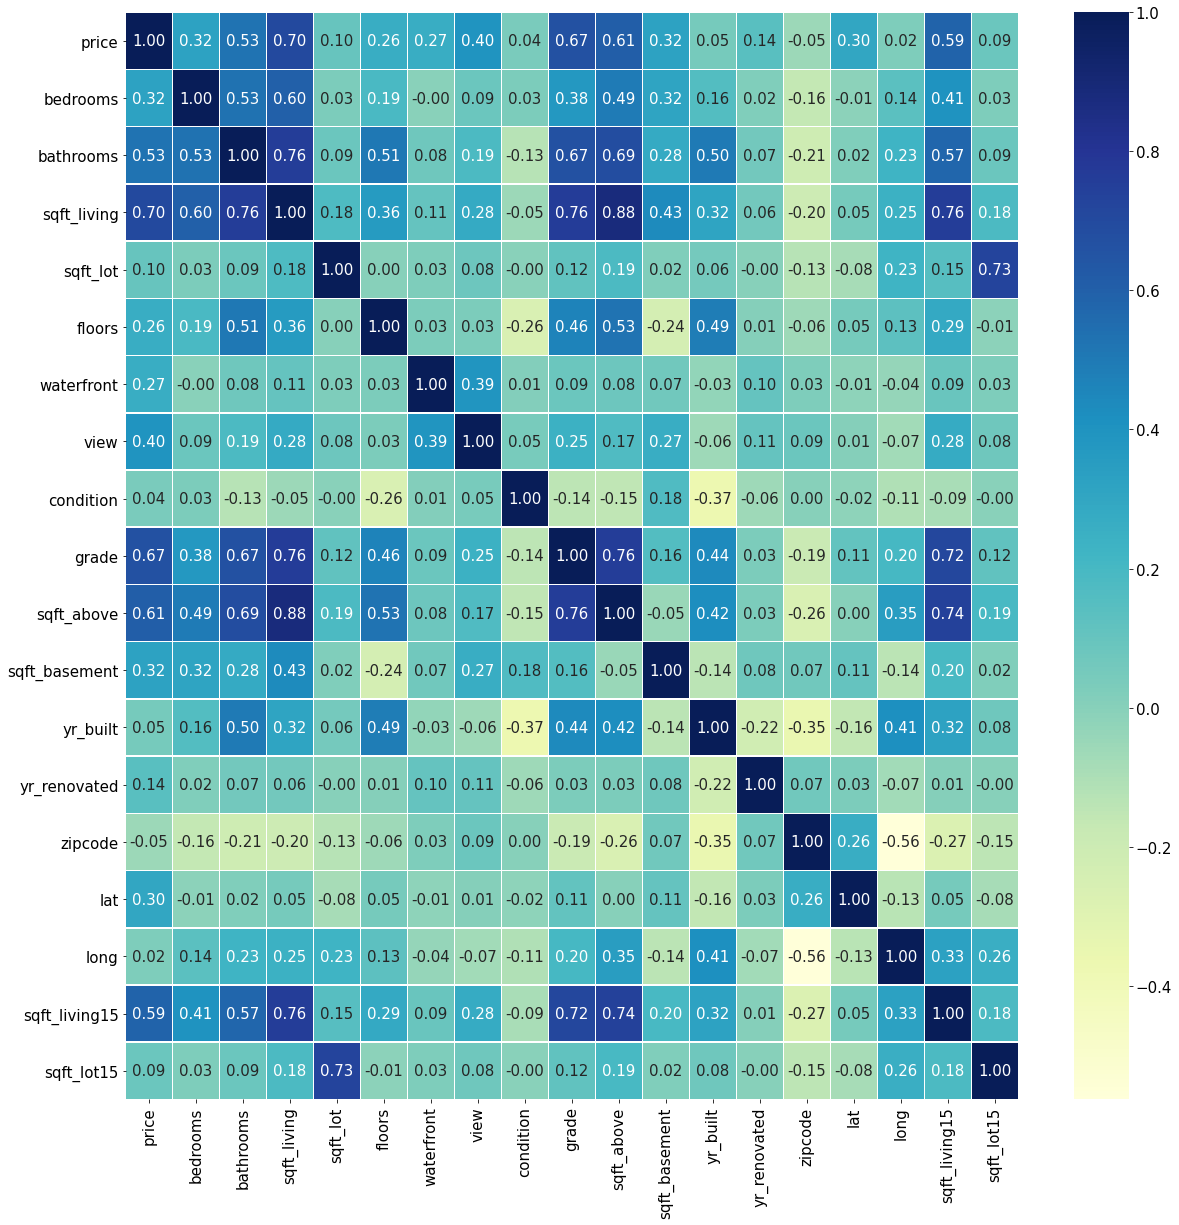

In [5]:
check = train.drop('date', axis=1)
check = train.drop('id', axis=1)

plt.figure(figsize=(20, 20))
sns.heatmap(data=check.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='YlGnBu')
plt.show()
# bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, grade, sqft_above, sqft_basement, lat, sqft_living15

## **✓ 간단한 전처리(결측치 확인)**  

- 빈 데이터와 전체 데이터의 분포를 확인하는 전처리 작업  
- 결측치, 빈 데이터가 있는지는 위에서 설치했던 missingno 라이브러리를 사용  
- 각 변수들에 대해 결측 유무를 확인 
- 분포를 확인해보면서 간단하게 전처리를 하겠습니다.  
- missingno 라이브러리의 matrix 함수(데이터의 결측 상태를 시각화)  


<AxesSubplot:>

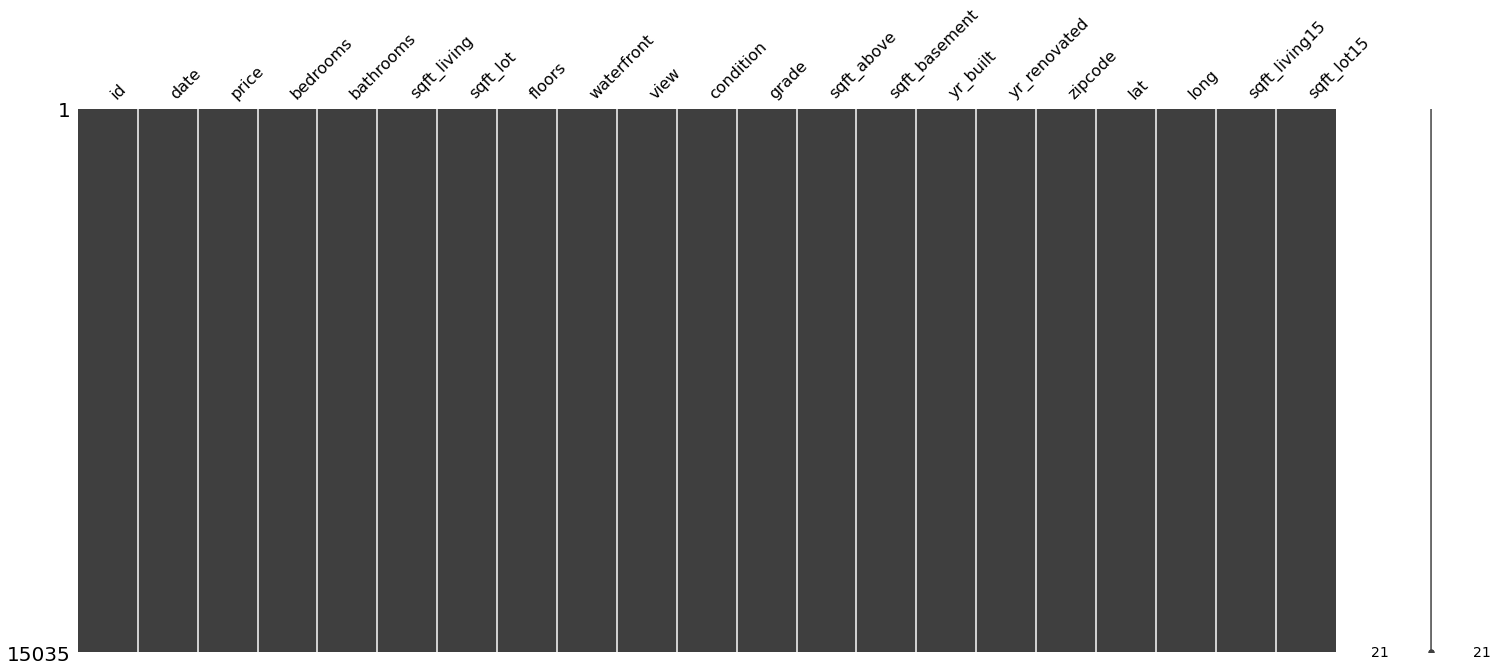

In [6]:
msno.matrix(train)

- 위에 출력된 것은 data라는 DataFrame을 매트릭스 모양 그대로 시각화  
- 특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 하얗게 나옴  
- 결측치가 없다면 매트릭스 전체가 까맣게 나옴  


In [7]:
y = train['price']

train.drop('price', axis=1, inplace=True)
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [8]:
#데이터 별로 NULL값 확인(column별로 결측치 개수 확인 : pd.isnull())
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))
    
#결측치가 없음

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


## **✓ 학습 데이터에서 라벨 제거하기**  

- price 컬럼은 따로 y라는 변수에 저장한 후 해당 컬럼은 지움

* 참고: w3schools - python del keyword  
* 참고로 데이터 분석 과정에서 칼럼을 없애고 싶다면 pandas.DataFrame.drop도 사용 가능

## **✓ 학습 데이터와 테스트 데이터 합치기**  

- 모델을 학습시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 `pd.concat`으로 합침
- 모델 학습을 진행할 때에는 다시 분리해서 사용
- 데이터를 합치기 전 `train_len에 training data의 개수`를 저장(학습데이터만 불러올 수 있는 인덱스로 사용)

In [9]:
#데이터 점검위해서 모든 데이터 합치기(pd,concat)
train_len = len(train)
data = pd.concat((train, test), axis=0)

print("train + test 갯수 :",len(data))

train + test 갯수 : 21503


In [10]:
#날짜 년도/월 6자리 뽑기
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int) 
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [11]:
# #ID 저장 후 제거
sub_id = data['id'][train_len:]    #train 이후 ~ test 마지막까지
data.drop('id', axis=1, inplace=True)

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [12]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## **✓ id, date 변수 정리**  

- 필요 없는 id 컬럼을 제거
- 나중에 예측 결과를 제출할 때를 대비(sub_id 변수에 id 칼럼을 저장)

- date 컬럼은 apply 함수로 필요한 부분만 잘라줌  
- 참고:Pandas Lambda, apply를 활용하여 복잡한 로직 적용

## **✓ 각 변수들의 분포 확인(시각화)**  
- 전체 데이터들의 분포를 확인  
- 너무 치우친 분포를 가는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향  
- 시각화 코드를 통해 id 컬럼을 제외한 19개 컬럼에 대해 한 번에 모든 그래프 그리기 
- 10행 2열의 subplot에 그래프를 그리기 위해 2중 for문을 사용  
- 그래프의 종류는 `sns.kdeplot`을 사용
- kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수  
- 참고: seaborn.kdeplot  

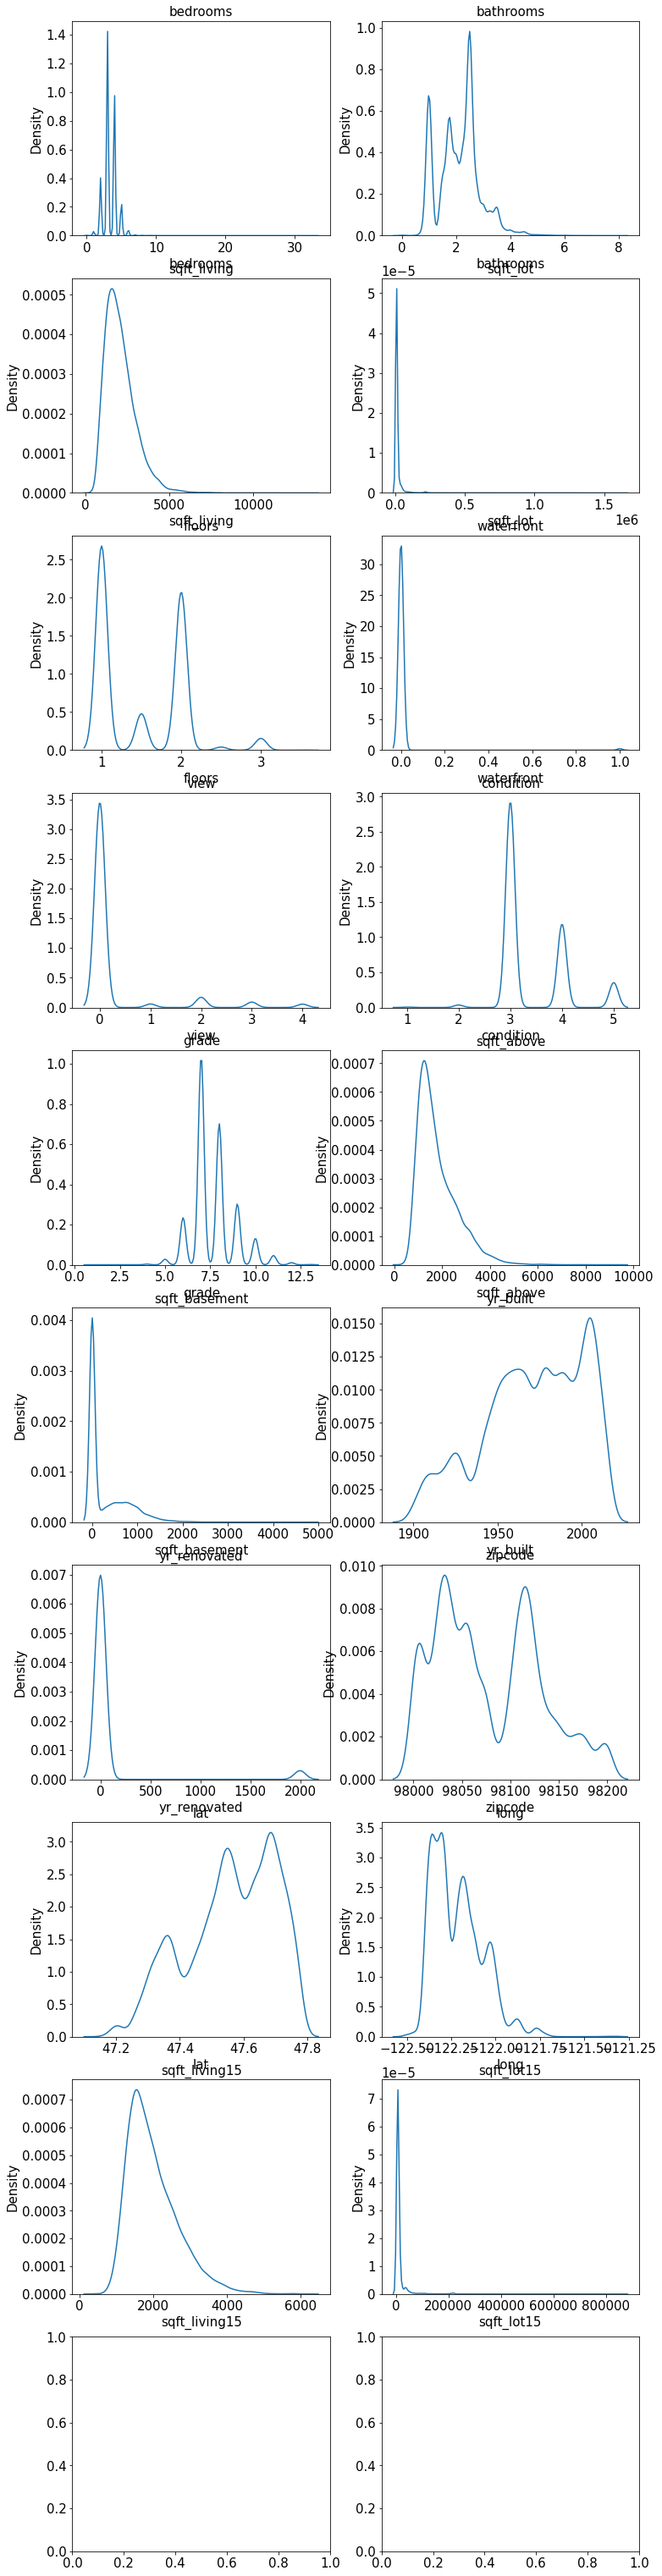

In [13]:
#데이터 분포 확인
fig, ax = plt.subplots(10, 2, figsize=(12, 55))   #  figsize의 x값, y값 인치 표현

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1

columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

## **✓그래프의 분포 (평가)**  

- 그래프 중에서는 `bedrooms`, `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement` 한쪽으로 치우친 경향  
- 한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포 만듦
- 치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환
- `numpy.log1p() 함수`는 입력 배열의 각 요소에 대해 `자연로그 log(1 + x)을 반환`해 주는 함수

In [14]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)


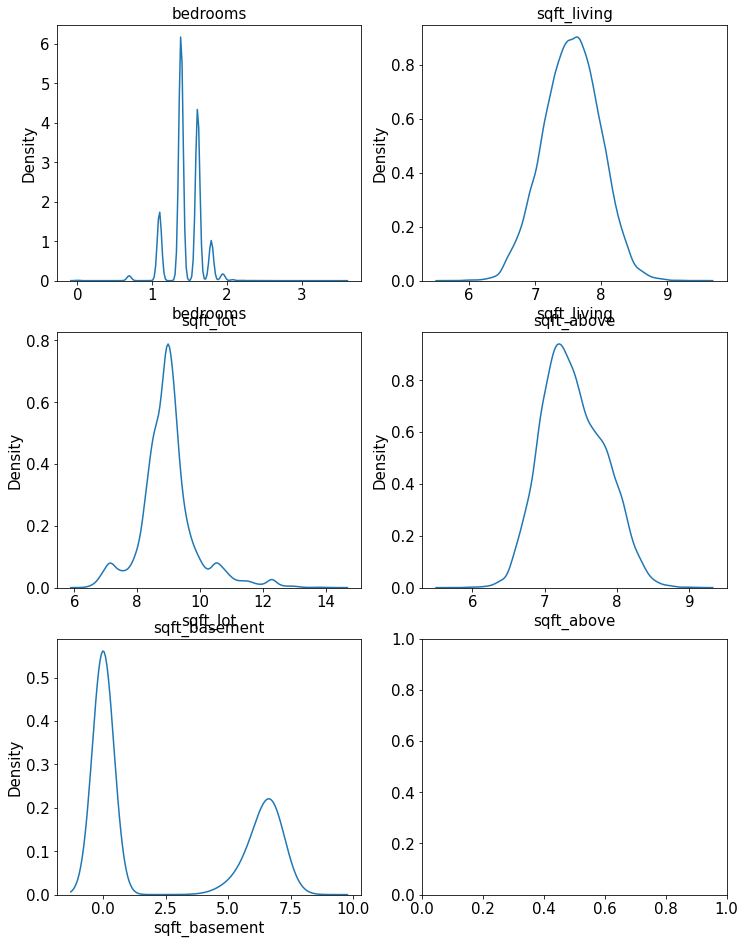

In [15]:
#자연로그 변환 후 그래프 그리기
fig, ax = plt.subplots(3, 2, figsize=(12, 16))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

값의 구간 내에 모이게 하는 특징
위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼짐

- 왜 한쪽으로 치우친 분포를 로그 변환을 취하게 되면 정규분포 모양으로 고르게 분포
- 타겟인 집의 가격, 즉 data[price]의 분포를 로그 변환했을 때 결과를 유추
- 원래 price의 분포

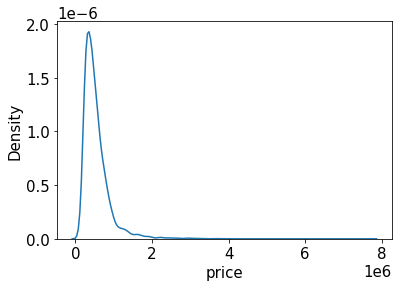

In [16]:
#저장해 둔 라벨 y값 사용
sns.kdeplot(y)
plt.show()

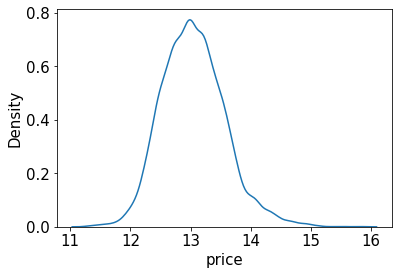

In [17]:
#라벨값 로그 변환
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

정규분포의 모양  

## **✓전처리 이후, Train과 Test 데이터 분활**  

In [18]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


## Step 4. custom 학습 데이터 만들기¶

In [19]:
#상관계수 높은 feature
tmp_lst = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'sqft_living15']

cust_train = pd.DataFrame()
for feature in tmp_lst:
    cust_train[feature] = train[feature]

cust_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_renovated,lat,sqft_living15
0,1.386294,1.00,7.074117,8.639588,1.0,0,0,7,7.074117,0.000000,0,47.5112,1340
1,1.098612,1.00,6.647688,9.210440,1.0,0,0,6,6.647688,0.000000,0,47.7379,2720
2,1.386294,2.00,7.427144,8.997271,1.0,0,0,8,7.427144,0.000000,0,47.6168,1800
3,1.386294,2.25,7.447751,8.827615,2.0,0,0,7,7.447751,0.000000,0,47.3097,2238
4,1.386294,1.50,6.966967,9.181118,1.0,0,0,7,6.966967,0.000000,0,47.4095,1650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,1.609438,2.50,7.832411,8.703507,2.0,0,0,9,7.832411,0.000000,0,47.5137,2520
15031,1.609438,3.50,8.163656,8.881975,2.0,0,0,9,7.863651,6.814543,0,47.5537,2050
15032,1.386294,2.50,7.333676,7.031741,3.0,0,0,8,7.333676,0.000000,0,47.6993,1530
15033,1.609438,2.50,7.745436,8.668024,2.0,0,0,8,7.745436,0.000000,0,47.5107,1830


## Step 4. custom 학습 데이터 만들어 보기¶

## Step 5. 모델 설계

## **✓ 모델링**  
- Baseline 커널에서는 여러 가지 모델을 함께 사용해서 결과를 섞는, 
`블렌딩(blending)`이라는 기법을 활용

- 블렌딩이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법  
`블렌딩은 앙상블 기법`

## **✓ Average Blending**  
- 여러 가지 모델의 결과를 산술평균하여 블렌딩 모델  
- 모델은 부스팅 계열인 `gboost, xgboost, lightgbm` 세 가지를 사용
    1. GradientBoosting
    2. XGBoosting
    3. LightGBM
    4. RandomForest(추가)

In [20]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [21]:
def get_scores(models, train, y):
    df = {}
    
    for model in models :
    
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE',ascending=False)
        
    return score_df

In [22]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [23]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=random_state).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y)), 
                                                  kf=kfold))

In [24]:
# 4가지 모델 생성
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [25]:
get_scores(models, cust_train, y)

,RMSE
GradientBoostingRegressor,160361.980376
RandomForestRegressor,156092.151533
LGBMRegressor,150759.568607
XGBRegressor,149451.182709


In [26]:
sc = get_scores(models, train, y)

In [27]:
sc.sort_values("RMSE", ascending=True)

,RMSE
XGBRegressor,110319.301793
LGBMRegressor,111906.947718
RandomForestRegressor,125325.083751
GradientBoostingRegressor,128360.173766


## Step 6. Grid Search

### LGBM


In [28]:
lgb_param_grid ={
    'n_estimators':[165,166,167,168,169, 170, 171],
    'max_depth':[8,9,10,20],
    'learning_rate' : [0.01, 0.1],
    'num_leaves' : [42,43,44],
    'boostingtype' : ['gbdt', 'rf']
}

In [29]:
lgb_model = lgb.LGBMRegressor(random_state=random_state)

In [30]:
result = my_GridSearch(lgb_model, train, y, lgb_param_grid)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:  1.9min finished


[LightGBM] [Warning] Unknown parameter: boostingtype


In [31]:
result.sort_values('RMSLE', ascending=True).head(15)

,boostingtype,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
118,gbdt,0.1,9,169,43,-0.026271,0.162082
286,rf,0.1,9,169,43,-0.026271,0.162082
115,gbdt,0.1,9,168,43,-0.026271,0.162084
283,rf,0.1,9,168,43,-0.026271,0.162084
121,gbdt,0.1,9,170,43,-0.026274,0.162091
289,rf,0.1,9,170,43,-0.026274,0.162091
124,gbdt,0.1,9,171,43,-0.026275,0.162096
292,rf,0.1,9,171,43,-0.026275,0.162096
280,rf,0.1,9,167,43,-0.026278,0.162105
112,gbdt,0.1,9,167,43,-0.026278,0.162105


### XGBoost

In [32]:
xgb_param_grid ={
    'n_estimators':[2000],  #1800],
    'max_depth':[9],
    'learning_rate' : [0.01],
    'booster' : ['dart'],
    'colsample_bytree':[0.6],
    'subsample' : [0.8]
}
xgboost = xgb.XGBRegressor(random_state=random_state)

In [33]:
xgb_result = my_GridSearch(xgboost, train, y, xgb_param_grid)
xgb_result.sort_values('RMSLE', ascending=True).head(15)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 92.1min remaining: 61.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 92.3min finished


,booster,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
0,dart,0.6,0.01,9,2000,0.8,-0.024637,0.156962


### GradientBoostingRegressor

In [34]:
gb_param_grid ={
    'n_estimators':[203,204,205,206,210],
    'max_depth':[6,7],
    'criterion' : ['mse'],
    'learning_rate' : [0.01, 0.1],
}

gboost = GradientBoostingRegressor(random_state=random_state)

In [35]:
gb_result = my_GridSearch(gboost, train, y, gb_param_grid)
gb_result.sort_values('RMSLE', ascending=True).head(15)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished


,criterion,learning_rate,max_depth,n_estimators,score,RMSLE
17,mse,0.10,7,205,-0.027048,0.164464
18,mse,0.10,7,206,-0.027052,0.164474
16,mse,0.10,7,204,-0.027053,0.164479
15,mse,0.10,7,203,-0.027059,0.164496
19,mse,0.10,7,210,-0.027059,0.164497
12,mse,0.10,6,205,-0.027103,0.164630
14,mse,0.10,6,210,-0.027110,0.164652
13,mse,0.10,6,206,-0.027111,0.164654
10,mse,0.10,6,203,-0.027116,0.164671
11,mse,0.10,6,204,-0.027120,0.164683


### RandomForestRegressor

In [36]:
rf_param_grid ={
    'n_estimators':[199, 200],
    'max_depth':[22, 23],
}
rdf = RandomForestRegressor(random_state=random_state)

In [37]:
rf_result = my_GridSearch(rdf, train, y, rf_param_grid)
rf_result.sort_values('RMSLE', ascending=True).head(15)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   29.6s remaining:   44.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   51.9s finished


,max_depth,n_estimators,score,RMSLE
1,22,200,-0.031508,0.177504
0,22,199,-0.031510,0.177511
3,23,200,-0.031538,0.177589
2,23,199,-0.031541,0.177599


## Step 7. Score 확인

In [38]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)
rdforest = RandomForestRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]



In [39]:
get_cv_score(models)

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Model GradientBoosting CV score : 0.8796
Model XGBoost CV score : 0.8973
Model LightGBM CV score : 0.9025
Model RandomForest CV score : 0.8854


## Step 8. 앙상블

In [40]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [41]:
# 기존의 로그변환한 y값을 다시 복원
y_pred = AveragingBlending(models, train, y, test)
y_pred = np.expm1(y_pred)

In [42]:
# 제출 파일 생성
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub

,id,price
0,15035,5.038286e+05
1,15036,4.457515e+05
2,15037,1.308205e+06
3,15038,3.048233e+05
4,15039,3.188626e+05
...,...,...
6463,21498,2.402504e+05
6464,21499,4.048343e+05
6465,21500,4.571148e+05
6466,21501,3.341518e+05


In [43]:
sub.to_csv('submission.csv', index=False)

## Step 9. 케글 제출

In [44]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [45]:
model = xgb.XGBRegressor(max_depth=9, n_estimators=2000, learning_rate=0.01, booster='dart', subsample=0.8, colsample_bytree=0.6, random_state=random_state)

save_submission(model, train, y, test, 'xgb', rmsle='0.156962')

/home/aiffel-dj56/aiffel/kaggle_kakr_housing/data/submission_xgb_RMSLE_0.156962.csv saved!


## ◈ 캐글 코리아 점수 확인

## 앙상블 시도 결과
![png](img/House_Price_Prediction-01.png)
![png](img/House_Price_Prediction-02.png)

## xgboost 결과
![png](img/House_Price_Prediction-03.png)
![png](img/House_Price_Prediction-04.png)


## ◈ 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항/상세기준  
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?  
데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.  

2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?  
제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.  

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?  
다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

## ◈ 결과 및 고찰

앙상블의 사용하여 price값을 예측하는 결과와 단일 모델을 사용하여 price값을 예측하는 결과를 비교해보니 앙상블을 사용하는 결과보다 좋은 Score를 얻었다. 이런 결과가 나온 이유는 모든 여러가지 모델로 예측한 값을 평균을 내어서 csv파일을 만들었기 때문이라고 생각해본다.
어떤 모델이 좋은 결과를 얻을지 모르는 상황에서는 안전빵 개념으로 다양한 모델로 학습된 결과로 앙상블한 결과로 신뢰성을 높이기 위한 의도가 아닐지 생각해 보았다. 

무엇을 해야하는지 몰라서 너무 오랜 시간 헤메였다.
중간에 원하던 데로 코드가 돌지 않아서 문제를 해결하는데에 너무 오랜 시간이 걸렸고 너무 진이 빠져서 프로젝트에 대한 흥미를 많이 잃게 되었다. 오래 붙잡고 공부한다고 해서 공부가 되지 않는다는 것을 느꼈다. 
결국 문제점은 로그로 변환한 값을 적절히 대입하지 않아서 였다.
또한, 하이퍼 파라메타를 조정하여 여러 가지 방법을 시도해 보고 싶었으나, 실행시간이 너무나도 오래 걸려서 다 실행될 때까지 기다리고 새로운 것을 해보는 것에는 문제가 있었다.
다음 번에는 학습 데이터 양을 램덤으로 뽑아서 적은 양의 데이터를 가지고 여러 가지를 시도해 보거나 하는 방법으로 코드 실행 시간을 줄여서 하이퍼 파라메터를 조정하거나 모델마다 다른 특성 등을 빨리 체크하고 확인하면서 공부를 해야 할 것이라고 생각이 되었다. 
